In [1]:
# Implements the Doubly robust value estimator for the learned policies

In [2]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle

In [3]:
df_train = pd.read_csv('../data/rl_train_data_final_cont.csv')
df_train.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input,reward
0,0.000000,3,7245052800,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.797351,0.939195,0.589916,0.750908,0.554500,0.0,4.0,0.125000
1,0.222560,3,7245067200,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.831780,0.934543,0.674384,0.819589,0.580033,0.0,4.0,0.657321
2,0.356608,3,7245081600,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.833222,0.656575,0.765423,0.939329,0.555033,0.0,2.0,1.367788
3,0.452837,3,7245096000,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834033,0.603831,0.783597,0.847073,0.545700,0.0,2.0,1.199099
4,0.527957,3,7245110400,0.0,0.412568,0.0,0.0,0,1,0.262712,...,0.0,0.0,0.834836,0.603831,0.794059,0.811583,0.539533,0.0,2.0,1.057596


In [4]:
df_val = pd.read_csv('../data/rl_val_data_final_cont.csv')

In [5]:
df_test = pd.read_csv('../data/rl_test_data_final_cont.csv')

In [6]:
test_actions = (5*df_test['iv_input'].values + df_test['vaso_input']).values.astype(int)

In [7]:
phys_policy_val = np.load('./MixNN_EM/marginal_lik_val_dr.npy')
phys_policy_test = np.load('./MixNN_EM/marginal_lik_test_dr.npy')

In [8]:
# # load in the policies for the physician on val and test sets
# phys_policy_val = pickle.load(open("val_policy.p", "rb" ))
# phys_policy_test = pickle.load(open("test_policy.p", "rb" ))

In [9]:
# get the indices for indexing into the policy matrix. 
indices = test_actions
phys_action_probs = phys_policy_test[range(len(phys_policy_test)),indices]

In [10]:
# Two cells below - load the actions and q values associated with the agent policy - these are outputted by the
# neural network used to learn the optimal policy and eval_policy respectively.

In [11]:
agent_actions = np.load('MixNN_EM/cond_lik_test_dr.npy')[:,:,3]
agent_q = np.load('./test_q_learned_policy.npy')

In [12]:
agent_reward_estimates = np.load('./test_rewards.npy')

In [13]:
# agent_actions = pickle.load(open('../continuous/dqn_normal/dqn_normal_actions_test.p', "rb" ))

In [14]:
# agent_q = pickle.load(open('../continuous/dqn_normal/dqn_normal_q_test.p', "rb" ))

In [15]:
# agent_reward_estimates = pickle.load(open('./test_rewards.p', "rb" ))
# agent_reward_estimates = agent_q

In [16]:
# add the actions and q values associated with agent performance on the test set to the dataframe

In [17]:
agent_actions_list = []
for i in agent_actions:
    agent_actions_list.append(list(i))

In [18]:
df_test['agent_action'] = agent_actions_list

In [19]:
df_test['agent_q'] = np.array(agent_q)

In [20]:
df_test['phys_prob'] = phys_action_probs

In [21]:
df_test['reward_estimate'] = agent_reward_estimates

In [22]:
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [23]:
unique_ids = df_test['icustayid'].unique()

In [24]:
print (np.mean (df_test['reward_estimate']))

0.9360575016732505


In [27]:
all_rhos = []

In [28]:
def val_estimate_recurse(traj,t):
#     print "Val estimate recurse, t is ", t
    ind = traj.index[t-1]
    reward_estimate = df_test.loc[ind,'reward_estimate']
#     state = df_test.loc[ind,'state']

    iv = df_test.loc[ind,'iv_input']
    vaso = df_test.loc[ind, 'vaso_input']
    phys_action = action_map[(iv,vaso)]
    phys_prob = df_test.loc[ind,'phys_prob']

    agent_action_arr = traj.loc[ind,'agent_action']
    
    agent_action_prob = agent_action_arr[phys_action]

    agent_val = traj.loc[ind, 'agent_q']

    reward = traj.loc[ind, 'reward']
    
    # calculate rho - the importance sampling factor    
#     TODO Consider making this stochastic?
#     if agent_action == phys_action:
#         rho = 1.0/phys_prob
#     else:
#         rho = 0

    rho = agent_action_prob / phys_prob
#     print "Val estimate recurse, rho is ", rho

        
    if t == len(traj):
        val_estimate = 0
    else:
        val_estimate = val_estimate_recurse(traj, t+1)
    
    all_rhos.append(rho)
    
#     print ("%d, vhat %f, rho %f, r_t %f, Vdr_recurse %f, Qhat %f,  " \
#                 % (t, reward_estimate, rho, reward, val_estimate, agent_val))
    
    return reward_estimate + rho*(reward + gamma*val_estimate - agent_val)

In [29]:
values = [] # contains the value estimates for each trajectory
# This discount factor (gamma) should be the same as that used to find Q(s,a) for the physician policy (sarsa_physician)
# and in eval_policy
gamma = 0.99
for i,uid in enumerate(unique_ids):
    trajectory = df_test.loc[df_test['icustayid'] == uid]
    cur_val = val_estimate_recurse(trajectory, 1)
    values.append(cur_val)

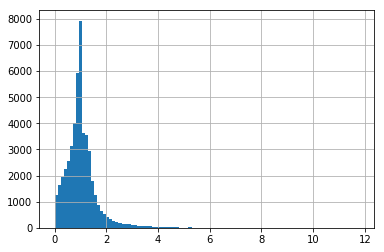

In [33]:
%matplotlib inline
pd.Series(all_rhos).hist(bins=100)

In [41]:
arr_rhos = np.array(all_rhos)
print(arr_rhos.mean(), arr_rhos.std(), max(arr_rhos), min(arr_rhos))
print(np.median(arr_rhos))

1.0263 0.63039 11.7726 1.82988e-07
0.961854


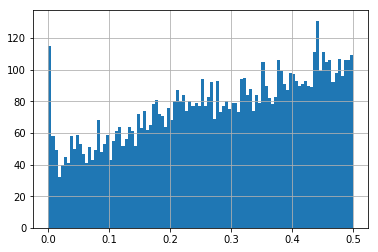

In [39]:
pd.Series(all_rhos)[arr_rhos<0.5].hist(bins = 100)

In [44]:
len(values)

2911

In [45]:
values = pd.Series(values)

# TODO - this is a hack to get rid of trajectories that resulted
# in extremely high values, as a result of rho being very large. 
# Think of a better way of doing this - perhaps by restricting
# the actions that the agent can take at any timestep?
# values = (values[(values >= -15) & (values <= 15)])

In [46]:
len(values)

2911

In [47]:
np.mean(values)

array([-31.26713045])

In [87]:
# Evaluate the average return under the physician policy on the test set.
phys_vals = []
gamma = 0.99
for uid in unique_ids:
    traj = df_test.loc[df_test['icustayid'] == uid]
    ret = 0
    reversed_traj = traj.iloc[::-1]
    for row in reversed_traj.index:
        ret = reversed_traj.loc[row,'reward'] + gamma*ret
    phys_vals.append(ret)
np.mean(phys_vals)

9.734491725447791